In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

In [2]:
# choose one: 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)  


In [3]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
#mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Correct the igrams so they are all referenced after topo corrections.

In [4]:
elev_cutoff = 150

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'

# set driver
driver=gdal.GetDriverByName('ISCE')

# load DEM for elev-dependent calculation.
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000
file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('DEM loaded.')
elev_min = min(elev.flatten())

# initialize arrays for all corrected igrams. 
igrams = np.ndarray((numIgrams,dy,dx),dtype='float')

# loop through igrams and correct each one. 
for i in range(numIgrams):

    # load the igram.
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    
    # calculate relationship with topography at elevations over elev_cutoff m (relationship applies best for bedrock/mtns)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    els = elev.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)

    #remove the topography effects
    temp_igram = temp_igram - (elev-elev_min) * m
    
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[ref_mask==1] = temp_igram[ref_mask==1]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_val = np.nanmean(ab) 

    # save corrected version to igrams array
    igrams[i] = temp_igram - avg_ref_val
    print('igram '+str(i)+' done.')

print('done.')
# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram, igram_masked, igram_filt, ab

DEM loaded.


/tmp/ipykernel_12264/3941358522.py:42: RuntimeWarning: invalid value encountered in true_divide
  ab = igram_filt / ref_mask_filt


igram 0 done.
igram 1 done.
igram 2 done.
igram 3 done.
igram 4 done.
igram 5 done.
igram 6 done.
igram 7 done.
igram 8 done.
igram 9 done.
igram 10 done.
igram 11 done.
igram 12 done.
igram 13 done.
igram 14 done.
igram 15 done.
igram 16 done.
igram 17 done.
igram 18 done.
igram 19 done.
igram 20 done.
igram 21 done.
igram 22 done.
igram 23 done.
igram 24 done.
igram 25 done.
igram 26 done.
igram 27 done.
igram 28 done.
igram 29 done.
igram 30 done.
igram 31 done.
igram 32 done.
igram 33 done.
igram 34 done.
igram 35 done.
igram 36 done.
igram 37 done.
igram 38 done.
igram 39 done.
igram 40 done.
igram 41 done.
igram 42 done.
igram 43 done.
igram 44 done.
igram 45 done.
igram 46 done.
igram 47 done.
igram 48 done.
igram 49 done.
igram 50 done.
igram 51 done.
igram 52 done.
igram 53 done.
igram 54 done.
igram 55 done.
igram 56 done.
igram 57 done.
igram 58 done.
igram 59 done.
igram 60 done.
igram 61 done.
igram 62 done.
igram 63 done.
igram 64 done.
igram 65 done.
igram 66 done.
igram

Load coherence files.

In [5]:
cohDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
coh = np.ndarray((numIgrams,dy,dx),dtype='float')

for i in range(numIgrams):
    # load one line of coherence files
    cohFile = 'coh_'+dates[i]+'-'+dates[i+1]+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    coh[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('coherence files loaded.')

coherence files loaded.


Extract the box I'm interested in: alluvial fan area.

In [6]:
box1x = [3000,3500];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]

phs_subset = igrams[:,box1y[0]:box1y[1],box1x[0]:box1x[1]]
coh_subset = coh[:,box1y[0]:box1y[1],box1x[0]:box1x[1]]

print(np.shape(igrams))
print(np.shape(phs_subset))

(210, 1100, 4000)
(210, 100, 500)


Plot for any igram the phases >pi/2 vs. coherence at those points, as a 2D histogram. 

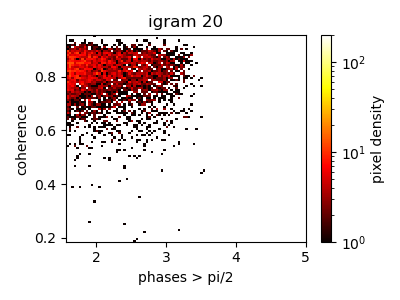

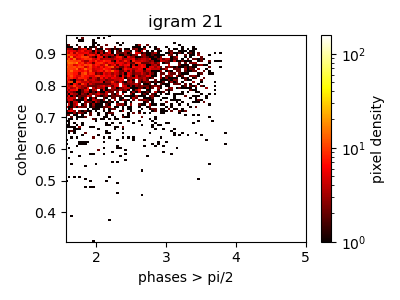

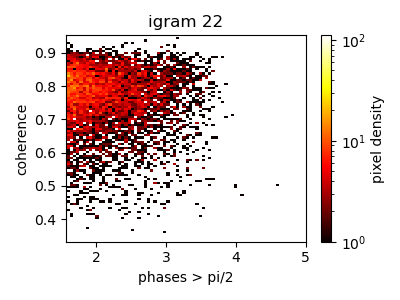

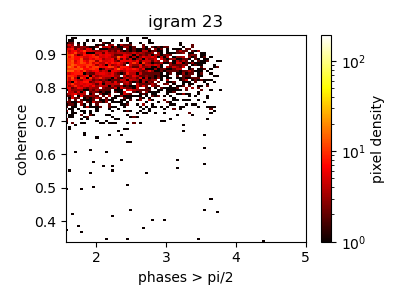

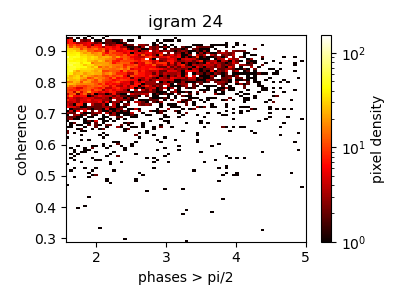

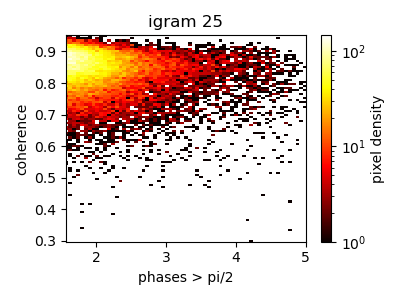

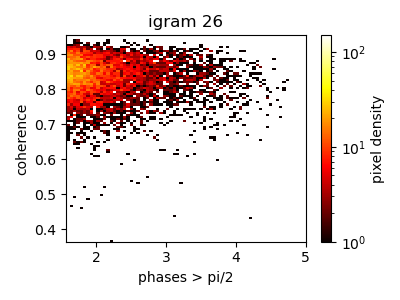

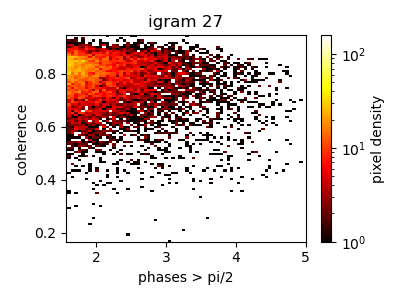

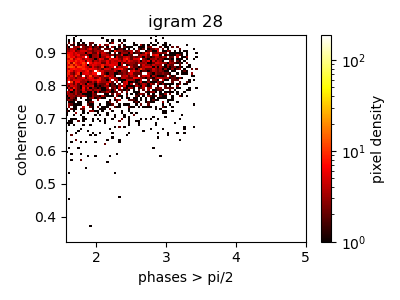

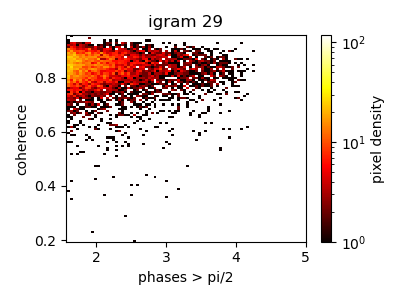

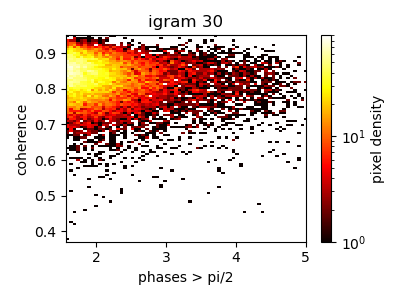

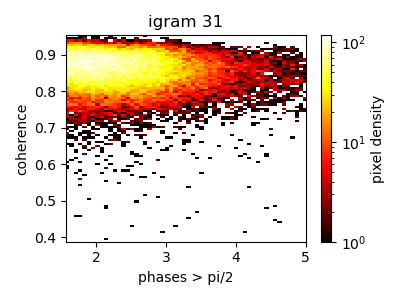

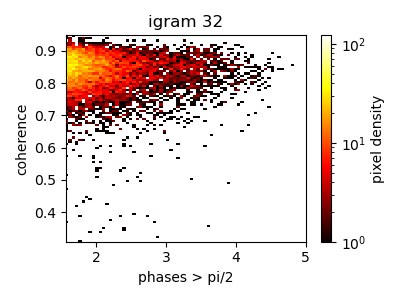

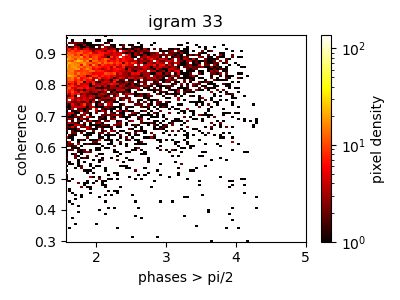

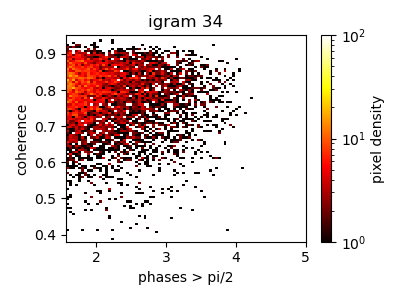

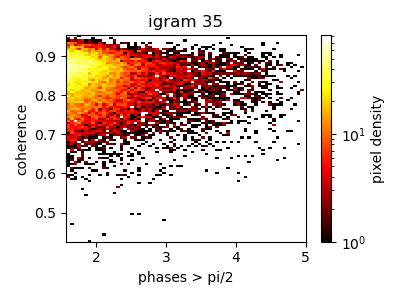

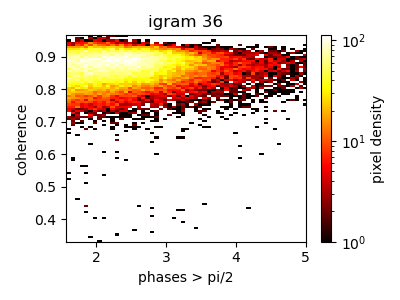

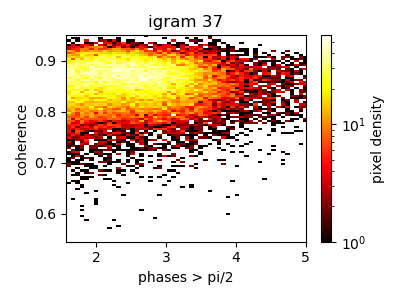

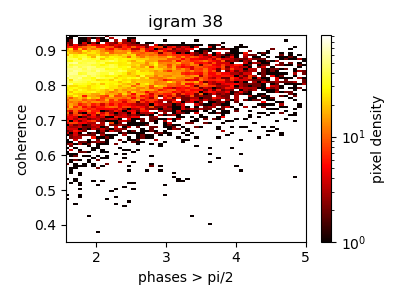

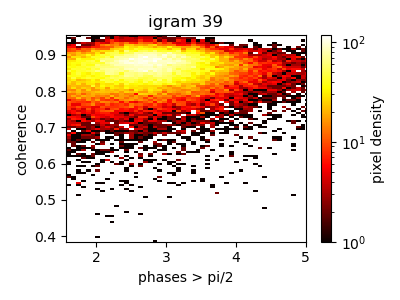

In [7]:
numBins = 100
import matplotlib.colors as mcolors
cutoff = np.pi/2


for i in np.arange(20,40,1):
    # pick out pixels with larger jumps than pi/2 or some cutoff 

    # print(phs_subset[i])
    # phs_jumps = phs_subset[i][abs(phs_subset)>cutoff]
    # coh_jumps = coh_subset[i][abs(phs_subset)>cutoff]

    plt.figure(figsize=(4,3),tight_layout=True)
    #plt.hist2d(abs(phs_jumps).flatten(),coh_jumps.flatten(),bins=numBins,norm=mcolors.LogNorm())
    plt.hist2d(abs(phs_subset[i]).flatten(),coh_subset[i].flatten(),bins=numBins,norm=mcolors.LogNorm())
    plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
    plt.hlines(cutoff,0,1,color='k',linestyle='--')
    plt.xlabel('phases > pi/2'); plt.ylabel('coherence')
    plt.xlim([cutoff,5]); #plt.ylim([0,1])
    plt.title('igram '+str(i))
    plt.show()
    #del phs_jumps, coh_jumps
